Using Ragas for evaluation: https://docs.ragas.io/en/latest/getstarted/index.html

In [ ]:
%pip install --upgrade pip

# Uninstall conflicting packages
%pip uninstall -y langchain_classic langchain-core langchain-openai langchain-community langchain chromadb beautifulsoup4 python-dotenv PyPDF2 rank_bm25

# Install compatible versions of langchain-core and langchain-openai
%pip install langchain-community==0.4.1
%pip install langchain-text-splitters==1.0.0
%pip install langchain-openai==1.1.0
%pip install langsmith==0.4.49
%pip install langchain==1.1.0

# Install remaining packages
%pip install langchain-chroma==1.0.0
%pip install chromadb==1.3.5
%pip install python-dotenv==1.2.1
%pip install PyPDF2==3.0.1 -q --user
%pip install rank_bm25==0.2.2
%pip uninstall uvloop -y

# new
%pip install ragas==0.4.0
%pip install tqdm==4.67.1 -q --user
%pip install matplotlib==3.10.7

In [1]:
import os
os.environ['USER_AGENT'] = 'RAGUserAgent'
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain_chroma import Chroma
import chromadb
from langchain_text_splitters import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from PyPDF2 import PdfReader
from langchain_core.documents import Document
from langchain_community.retrievers import BM25Retriever
from langchain_classic.retrievers import EnsembleRetriever

## new
import tqdm as notebook_tqdm
import pandas as pd
import matplotlib.pyplot as plt
from ragas import EvaluationDataset, SingleTurnSample, evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.testset import TestsetGenerator
from ragas.testset.synthesizers.single_hop.specific import SingleHopSpecificQuerySynthesizer
from ragas.metrics import (
    LLMContextRecall,
    Faithfulness,
    FactualCorrectness,
    ResponseRelevancy,
    LLMContextPrecisionWithoutReference,
    SemanticSimilarity
)

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# variables
_ = load_dotenv(dotenv_path='env.txt')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
embedding_function = OpenAIEmbeddings()
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
pdf_path = "google-2023-environmental-report.pdf"
collection_name = "google_environmental_report"
str_output_parser = StrOutputParser()
user_query = "What are Google's environmental initiatives?"

In [3]:
# LLMs/Embeddings
embedding_ada = "text-embedding-ada-002"
model_gpt4omini = "gpt-4o-mini"
model_gpt4o = "gpt-4o"

embedding_function = OpenAIEmbeddings(model=embedding_ada, openai_api_key=openai.api_key)
llm = ChatOpenAI(model=model_gpt4omini, openai_api_key=openai.api_key, temperature=0.0)

# Generator LLM for testset generation
generator_llm_raw = ChatOpenAI(model=model_gpt4omini, openai_api_key=openai.api_key, temperature=0.0)
generator_llm = LangchainLLMWrapper(generator_llm_raw)
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model=embedding_ada, openai_api_key=openai.api_key))

# Critic LLM for evaluation
critic_llm_raw = ChatOpenAI(model=model_gpt4o, openai_api_key=openai.api_key, temperature=0.0)
embeddings_raw = OpenAIEmbeddings(model=embedding_ada, openai_api_key=openai.api_key)
critic_llm_wrapped = LangchainLLMWrapper(critic_llm_raw)
embeddings_wrapped = LangchainEmbeddingsWrapper(embeddings_raw)


/var/folders/pf/g8xt3fvd26n9h2z96v_vgnt80000gn/T/ipykernel_6561/1903404535.py:11: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  generator_llm = LangchainLLMWrapper(generator_llm_raw)
/var/folders/pf/g8xt3fvd26n9h2z96v_vgnt80000gn/T/ipykernel_6561/1903404535.py:12: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings(model=embedding_ada, openai_api_key=openai.api_key))
/var/folders/pf/g8xt3fvd26n9h2z96v_vgnt80000gn/T/ipykernel_6561/1903404535.py:17: Deprecation

In [ ]:
#### INDEXING ####

In [4]:
# # Load the PDF and extract text
pdf_reader = PdfReader(pdf_path)
text = ""
for page in pdf_reader.pages:
    text += page.extract_text()

In [5]:
# Split
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=200
)
splits = character_splitter.split_text(text)

In [6]:
dense_documents = [Document(page_content=text, metadata={"id": str(i), "source": "dense"}) for i, text in enumerate(splits)]
sparse_documents = [Document(page_content=text, metadata={"id": str(i), "source": "sparse"}) for i, text in enumerate(splits)]

In [7]:
chroma_client = chromadb.Client()
vectorstore = Chroma.from_documents(
    documents=dense_documents,
    embedding=embedding_function,
    collection_name=collection_name,
    client=chroma_client
)

In [8]:
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
sparse_retriever = BM25Retriever.from_documents(sparse_documents, k=10)
ensemble_retriever = EnsembleRetriever(retrievers=[dense_retriever, sparse_retriever], weights=[0.5, 0.5], c=0)

In [ ]:
#### RETRIEVAL and GENERATION ####

In [9]:
# Prompt
client = Client()
prompt = client.pull_prompt("jclemens24/rag-prompt")

In [10]:
# Relevance check prompt
relevance_prompt_template = PromptTemplate.from_template(
    """
    Given the following question and retrieved context, determine if the context is relevant to the question.
    Provide a score from 1 to 5, where 1 is not at all relevant and 5 is highly relevant.
    Return ONLY the numeric score, without any additional text or explanation.

    Question: {question}
    Retrieved Context: {retrieved_context}

    Relevance Score:"""
)

In [11]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [12]:
def extract_score(llm_output):
    try:
        score = float(llm_output.strip())
        return score
    except ValueError:
        return 0

# Chain it all together with LangChain
def conditional_answer(x):
    relevance_score = extract_score(x['relevance_score'])
    if relevance_score < 4:
        return "I don't know."
    else:
        return x['answer']

In [13]:
rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | RunnableParallel(
        {"relevance_score": (
            RunnablePassthrough()
            | (lambda x: relevance_prompt_template.format(question=x['question'], retrieved_context=x['context']))
            | llm
            | str_output_parser
        ), "answer": (
            RunnablePassthrough()
            | prompt
            | llm
            | str_output_parser
        )}
    )
    | RunnablePassthrough().assign(final_answer=conditional_answer)
)

In [14]:
rag_chain_similarity = RunnableParallel(
    {"context": dense_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)

In [15]:
rag_chain_hybrid = RunnableParallel(
    {"context": ensemble_retriever,
     "question": RunnablePassthrough()
}).assign(answer=rag_chain_from_docs)

In [16]:
# Question - Submitted to the similarity / dense vector search
result = rag_chain_similarity.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Similarity Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

Original Question to Similarity Search: What are Google's environmental initiatives?

Relevance Score: 5

Final Answer:
Google's environmental initiatives focus on three key pillars: empowering individuals, working together with partners and customers, and operating sustainably. Some specific initiatives include:

1. **Empowering Individuals**: Google aims to help 1 billion people make more sustainable choices through features like eco-friendly routing in Google Maps, energy efficiency in Google Nest thermostats, and carbon emissions information in Google Flights.

2. **Sustainable Operations**: Google has committed to achieving net-zero carbon emissions and operates its Bay View campus, which is all-electric and net water-positive. The campus also incorporates principles of circular design.

3. **Collaboration and Partnerships**: Google is involved in various coalitions and initiatives, such as the iMasons Climate Accord for carbon reduction in digital infrastructure and the ReFED Cat

In [17]:
# Question - Submitted to the hybrid / multi-vector search
result = rag_chain_hybrid.invoke(user_query)
retrieved_docs = result['context']

print(f"Original Question to Dense Search: {user_query}\n")
print(f"Relevance Score: {result['answer']['relevance_score']}\n")
print(f"Final Answer:\n{result['answer']['final_answer']}\n\n")
print("Retrieved Documents:")
for i, doc in enumerate(retrieved_docs, start=1):
    print(f"Document {i}: Document ID: {doc.metadata['id']} source: {doc.metadata['source']}")
    print(f"Content:\n{doc.page_content}\n")

Original Question to Dense Search: What are Google's environmental initiatives?

Relevance Score: 5

Final Answer:
Google's environmental initiatives focus on several key areas:

1. **Empowering Individuals**: Google aims to help 1 billion people make more sustainable choices through features in its products, such as eco-friendly routing in Google Maps and energy efficiency features in Google Nest thermostats.

2. **Working Together**: Google collaborates with partners and customers to advance technology for sustainability. This includes initiatives like the iMasons Climate Accord for carbon reduction in digital infrastructure and funding for food waste solutions through the ReFED Catalytic Grant Fund.

3. **Operating Sustainably**: Google has committed to achieving net-zero carbon emissions and operates its data centers with a focus on energy efficiency. The new Bay View campus is designed to be all-electric and net water-positive.

4. **Water Stewardship and Circular Economy**: Googl

#### SIMILARITY SEARCH ONLY
Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, water stewardship, and promoting a circular economy. They have implemented sustainability features in products like Google Maps, Google Nest thermostats, and Google Flights to help individuals make more sustainable choices. Google also supports various environmental organizations and initiatives, such as the iMasons Climate Accord, ReFED, and The Nature Conservancy, to accelerate climate action and address environmental challenges. Additionally, Google is involved in public policy advocacy and is committed to reducing its environmental impact through its operations and value chain.


#### HYBRID SEARCH

Google's environmental initiatives include empowering individuals to take action, working together with partners and customers, operating sustainably, achieving net-zero carbon emissions, focusing on water stewardship, promoting a circular economy, engaging with suppliers to reduce energy consumption and greenhouse gas emissions, and reporting environmental data. They also support public policy and advocacy for low-carbon economies, participate in initiatives like the iMasons Climate Accord and ReFED, and support projects with organizations like The Nature Conservancy. Additionally, Google is involved in initiatives with the World Business Council for Sustainable Development and the World Resources Institute to improve well-being for people and the planet. They are also working on using technology and platforms to organize information about the planet and make it actionable to help partners and customers create a positive impact.

### SYNTHETIC DATA GENERATION

In [18]:
# Create generator with wrapped LLMs
generator = TestsetGenerator(
    llm=generator_llm,
    embedding_model=generator_embeddings
)

In [19]:
# Prepare documents
documents = [Document(page_content=chunk) for chunk in splits]

# Define query distribution (only single-hop)
query_distribution = [
    (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 1.0),
]

# Generate testset
testset = generator.generate_with_langchain_docs(
    documents,
    testset_size=10,
    query_distribution=query_distribution
)

Applying CustomNodeFilter:  61%|██████    | 277/453 [01:28<01:12,  2.44it/s]Node 2217dcdb-cb7e-4ab3-bf2e-7a30ca7691e6 does not have a summary. Skipping filtering.
Node eff124d5-ab3d-486a-b178-b592cbbef8ca does not have a summary. Skipping filtering.
Node 1d440016-544d-48ef-a0e9-981e54aa1dcd does not have a summary. Skipping filtering.
Generating Samples: 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]


In [20]:
# comparison dataframe
testset_df = testset.to_pandas()

# save dataframes to CSV files in the specified directory
testset_df.to_csv(os.path.join('testset_data.csv'), index=False)

print("testset DataFrame saved successfully in the local directory.")

testset DataFrame saved successfully in the local directory.


In [21]:
# pull data from saved testset, rather than generating above
### load dataframs from CSV file
saved_testset_df = pd.read_csv(os.path.join('testset_data.csv'))
print("testset DataFrame loaded successfully from local directory.")
saved_testset_df.head(5)

testset DataFrame loaded successfully from local directory.


,user_input,reference_contexts,reference,persona_name,query_style,query_length,synthesizer_name
0,What are the key highlights and targets mentio...,['Environmental \nReport\n2023What’s \ninside\...,Google’s 2023 Environmental Report provides an...,Energy Analyst,MISSPELLED,LONG,single_hop_specific_query_synthesizer
1,What about Mountain View?,['Highlights 6\nOur sustainability strategy 7...,Spotlight: Building a more sustainable campus ...,Energy Analyst,POOR_GRAMMAR,SHORT,single_hop_specific_query_synthesizer
2,What key topics are covered in the 2023 Enviro...,['About Google\n 76\nSustainab i\nlity governa...,The 2023 Environmental Report covers various k...,Environmental Data Scientist,WEB_SEARCH_LIKE,MEDIUM,single_hop_specific_query_synthesizer
3,What actions are being taken for Learning and ...,['4\n2023 Environmental Report \nExecutive le...,Actions for Learning and Sustainability in res...,Environmental Data Scientist,POOR_GRAMMAR,MEDIUM,single_hop_specific_query_synthesizer
4,What Google do for renewable energy?,"['I worked on Search for 20 years, leading the...",Google has matched 100% of its global electric...,Energy Analyst,POOR_GRAMMAR,SHORT,single_hop_specific_query_synthesizer


### PREPARE SIMILARITY SEARCH DATASET

In [22]:
# PREPARE EVALUATION DATASETS
# Function to generate samples
def generate_ragas_sample(question, ground_truth, rag_chain):
    result = rag_chain.invoke(question)
    
    return SingleTurnSample(
        user_input=question,
        response=result["answer"]["final_answer"],
        retrieved_contexts=[doc.page_content for doc in result["context"]],
        reference=ground_truth
    )

### EVAL SETS FOR EACH CHAIN

In [23]:
# Generate samples for similarity search
similarity_samples = []
for _, row in saved_testset_df.iterrows():
    try:
        sample = generate_ragas_sample(
            row["user_input"], 
            row["reference"],
            rag_chain_similarity
        )
        similarity_samples.append(sample)
    except Exception as e:
        print(f"Error: {e}")
        continue

evaluation_dataset_similarity = EvaluationDataset(samples=similarity_samples)

In [24]:
# Generate samples for hybrid search
hybrid_samples = []
for _, row in saved_testset_df.iterrows():
    try:
        sample = generate_ragas_sample(
            row["user_input"], 
            row["reference"],
            rag_chain_hybrid
        )
        hybrid_samples.append(sample)
    except Exception as e:
        print(f"Error: {e}")
        continue

evaluation_dataset_hybrid = EvaluationDataset(samples=hybrid_samples)

### EVAL SCORING

In [25]:
# Initialize metrics with wrapped LLMs
metrics = [
    Faithfulness(llm=critic_llm_wrapped),
    ResponseRelevancy(llm=critic_llm_wrapped, embeddings=embeddings_wrapped),
    LLMContextPrecisionWithoutReference(llm=critic_llm_wrapped),
    LLMContextRecall(llm=critic_llm_wrapped),
    FactualCorrectness(llm=critic_llm_wrapped),
    SemanticSimilarity(embeddings=embeddings_wrapped)
]

In [26]:
# Evaluate similarity search
print("Evaluating similarity search...")
score_similarity = evaluate(
    dataset=evaluation_dataset_similarity,
    metrics=metrics
)

similarity_df = score_similarity.to_pandas()
similarity_df

Evaluating similarity search...


Evaluating:   2%|▏         | 1/60 [00:01<01:55,  1.95s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 60/60 [01:14<00:00,  1.25s/it]


,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,llm_context_precision_without_reference,context_recall,factual_correctness(mode=f1),semantic_similarity
0,What are the key highlights and targets mentio...,[Environmental \nReport\n2023What’s \ninside\n...,The key highlights and targets mentioned in Go...,Google’s 2023 Environmental Report provides an...,1.000000,0.993462,0.125000,1.0,0.00,0.924923
1,What about Mountain View?,[Our headquarters are located in Mountain View...,"Mountain View, California, is home to Google's...",Spotlight: Building a more sustainable campus ...,1.000000,0.864761,0.392857,1.0,0.19,0.881619
2,What key topics are covered in the 2023 Enviro...,[Environmental \nReport\n2023What’s \ninside\n...,The key topics covered in the 2023 Environment...,The 2023 Environmental Report covers various k...,1.000000,0.997051,0.500000,1.0,0.22,0.909106
3,What actions are being taken for Learning and ...,[4\n2023 Environmental Report \nExecutive let...,Actions being taken for Learning and Sustainab...,Actions for Learning and Sustainability in res...,1.000000,0.943395,0.337302,1.0,0.00,0.896820
4,What Google do for renewable energy?,[that Google can make a meaningful difference ...,Google is actively involved in renewable energ...,Google has matched 100% of its global electric...,1.000000,0.951209,0.579167,0.0,0.26,0.901154
5,What is the goal of using carbon-free energy i...,[2023 Environmental Report Advancing carbon-f...,The goal of using carbon-free energy in operat...,The goal is to achieve net-zero emissions acro...,0.857143,1.000000,0.825397,1.0,0.40,0.937003
6,How Google help with climate info and action?,"[Beyond our own footprint, Google’s founding m...",Google helps with climate information and acti...,Google’s founding mission to organize the worl...,1.000000,0.988539,0.716667,1.0,0.42,0.925215
7,How can the Erth Engine help in making informa...,[Helpful information can be critical in both ...,"The Erth Engine, specifically Google Earth Eng...",The Earth Engine is one of the key solutions t...,0.500000,0.965757,0.731111,1.0,0.40,0.938972
8,How AI help with climate change and weather pr...,[Prediction: Using AI to help communities addr...,AI helps with climate change and weather predi...,AI solutions can help in predicting more extre...,1.000000,0.979511,0.947222,1.0,0.22,0.937048
9,What role does California play in sustainabili...,[create a more sustainable future. 5\n2023 E...,California plays a significant role in sustain...,The context mentions that the speaker grew up ...,1.000000,0.980016,0.000000,1.0,0.00,0.873861


In [27]:
# Evaluate hybrid search
print("Evaluating hybrid search...")
score_hybrid = evaluate(
    dataset=evaluation_dataset_hybrid,
    metrics=metrics
)

hybrid_df = score_hybrid.to_pandas()
hybrid_df

Evaluating hybrid search...


Evaluating:   2%|▏         | 1/60 [00:01<01:56,  1.98s/it]LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.
Evaluating: 100%|██████████| 60/60 [01:39<00:00,  1.66s/it]


,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,llm_context_precision_without_reference,context_recall,factual_correctness(mode=f1),semantic_similarity
0,What are the key highlights and targets mentio...,[approximately 2.8 GW of clean energy \ngenera...,The key highlights and targets mentioned in Go...,Google’s 2023 Environmental Report provides an...,1.000000,0.993462,1.000000,1.0,0.11,0.919428
1,What about Mountain View?,[Our headquarters are located in Mountain View...,"Mountain View, California, is home to Google's...",Spotlight: Building a more sustainable campus ...,1.000000,0.834588,0.316667,1.0,0.27,0.892754
2,What key topics are covered in the 2023 Enviro...,[Environmental \nReport\n2023What’s \ninside\n...,The key topics covered in the 2023 Environment...,The 2023 Environmental Report covers various k...,1.000000,0.997052,0.229167,1.0,0.13,0.904801
3,What actions are being taken for Learning and ...,[4\n2023 Environmental Report \nExecutive let...,"In response to climate change, several actions...",Actions for Learning and Sustainability in res...,1.000000,0.928641,0.245166,1.0,0.00,0.885322
4,What Google do for renewable energy?,[that Google can make a meaningful difference ...,Google is actively involved in promoting renew...,Google has matched 100% of its global electric...,1.000000,0.968673,0.351587,1.0,0.33,0.915225
5,What is the goal of using carbon-free energy i...,[2023 Environmental Report Advancing carbon-f...,The goal of using carbon-free energy in operat...,The goal is to achieve net-zero emissions acro...,0.857143,1.000000,0.781429,1.0,0.22,0.938500
6,How Google help with climate info and action?,"[Beyond our own footprint, Google’s founding m...",Google helps with climate information and acti...,Google’s founding mission to organize the worl...,0.933333,0.974209,0.535465,1.0,0.37,0.911501
7,How can the Erth Engine help in making informa...,[Helpful information can be critical in both ...,The Erth Engine can help make information more...,The Earth Engine is one of the key solutions t...,1.000000,0.968935,0.513095,1.0,0.63,0.936354
8,How AI help with climate change and weather pr...,[Prediction: Using AI to help communities addr...,AI helps with climate change and weather predi...,AI solutions can help in predicting more extre...,0.882353,0.992165,0.613776,1.0,0.36,0.940271
9,What role does California play in sustainabili...,"[And for innovation, we’ll call out the many ...",I don't know.,The context mentions that the speaker grew up ...,0.000000,0.000000,0.000000,1.0,0.00,0.761963


### ANALYSIS

In [28]:
# ANALYSIS
key_columns = [
    'faithfulness',
    'answer_relevancy',
    'llm_context_precision_without_reference',
    'context_recall',
    'factual_correctness(mode=f1)',
    'semantic_similarity'
]

similarity_means = similarity_df[key_columns].mean()
hybrid_means = hybrid_df[key_columns].mean()

comparison_df = pd.DataFrame({
    'Similarity Run': similarity_means, 
    'Hybrid Run': hybrid_means
})
comparison_df['Difference'] = comparison_df['Similarity Run'] - comparison_df['Hybrid Run']

# Save dataframes
similarity_df.to_csv(os.path.join('similarity_run_data.csv'), index=False)
hybrid_df.to_csv(os.path.join('hybrid_run_data.csv'), index=False)
comparison_df.to_csv(os.path.join('comparison_data.csv'), index=True)

print("Dataframes saved successfully in the local directory.")

Dataframes saved successfully in the local directory.


In [29]:
# Load and print comparison
sem_df = pd.read_csv(os.path.join('similarity_run_data.csv'))
rec_df = pd.read_csv(os.path.join('hybrid_run_data.csv'))
comparison_df = pd.read_csv(os.path.join('comparison_data.csv'), index_col=0)

print("Dataframes loaded successfully from the local directory.")
print("Performance Comparison:")
print("\n**Retrieval**:")
print(comparison_df.loc[['llm_context_precision_without_reference', 'context_recall']])
print("\n**Generation**:")
print(comparison_df.loc[['faithfulness', 'answer_relevancy']])
print("\n**End-to-end evaluation**:")
print(comparison_df.loc[['factual_correctness(mode=f1)', 'semantic_similarity']])

Dataframes loaded successfully from the local directory.
Performance Comparison:

**Retrieval**:
                                         Similarity Run  Hybrid Run  \
llm_context_precision_without_reference        0.515472    0.458635   
context_recall                                 0.900000    1.000000   

                                         Difference  
llm_context_precision_without_reference    0.056837  
context_recall                            -0.100000  

**Generation**:
                  Similarity Run  Hybrid Run  Difference
faithfulness            0.935714    0.867283    0.068431
answer_relevancy        0.966370    0.865772    0.100598

**End-to-end evaluation**:
                              Similarity Run  Hybrid Run  Difference
factual_correctness(mode=f1)        0.211000    0.242000    -0.03100
semantic_similarity                 0.912572    0.900612     0.01196


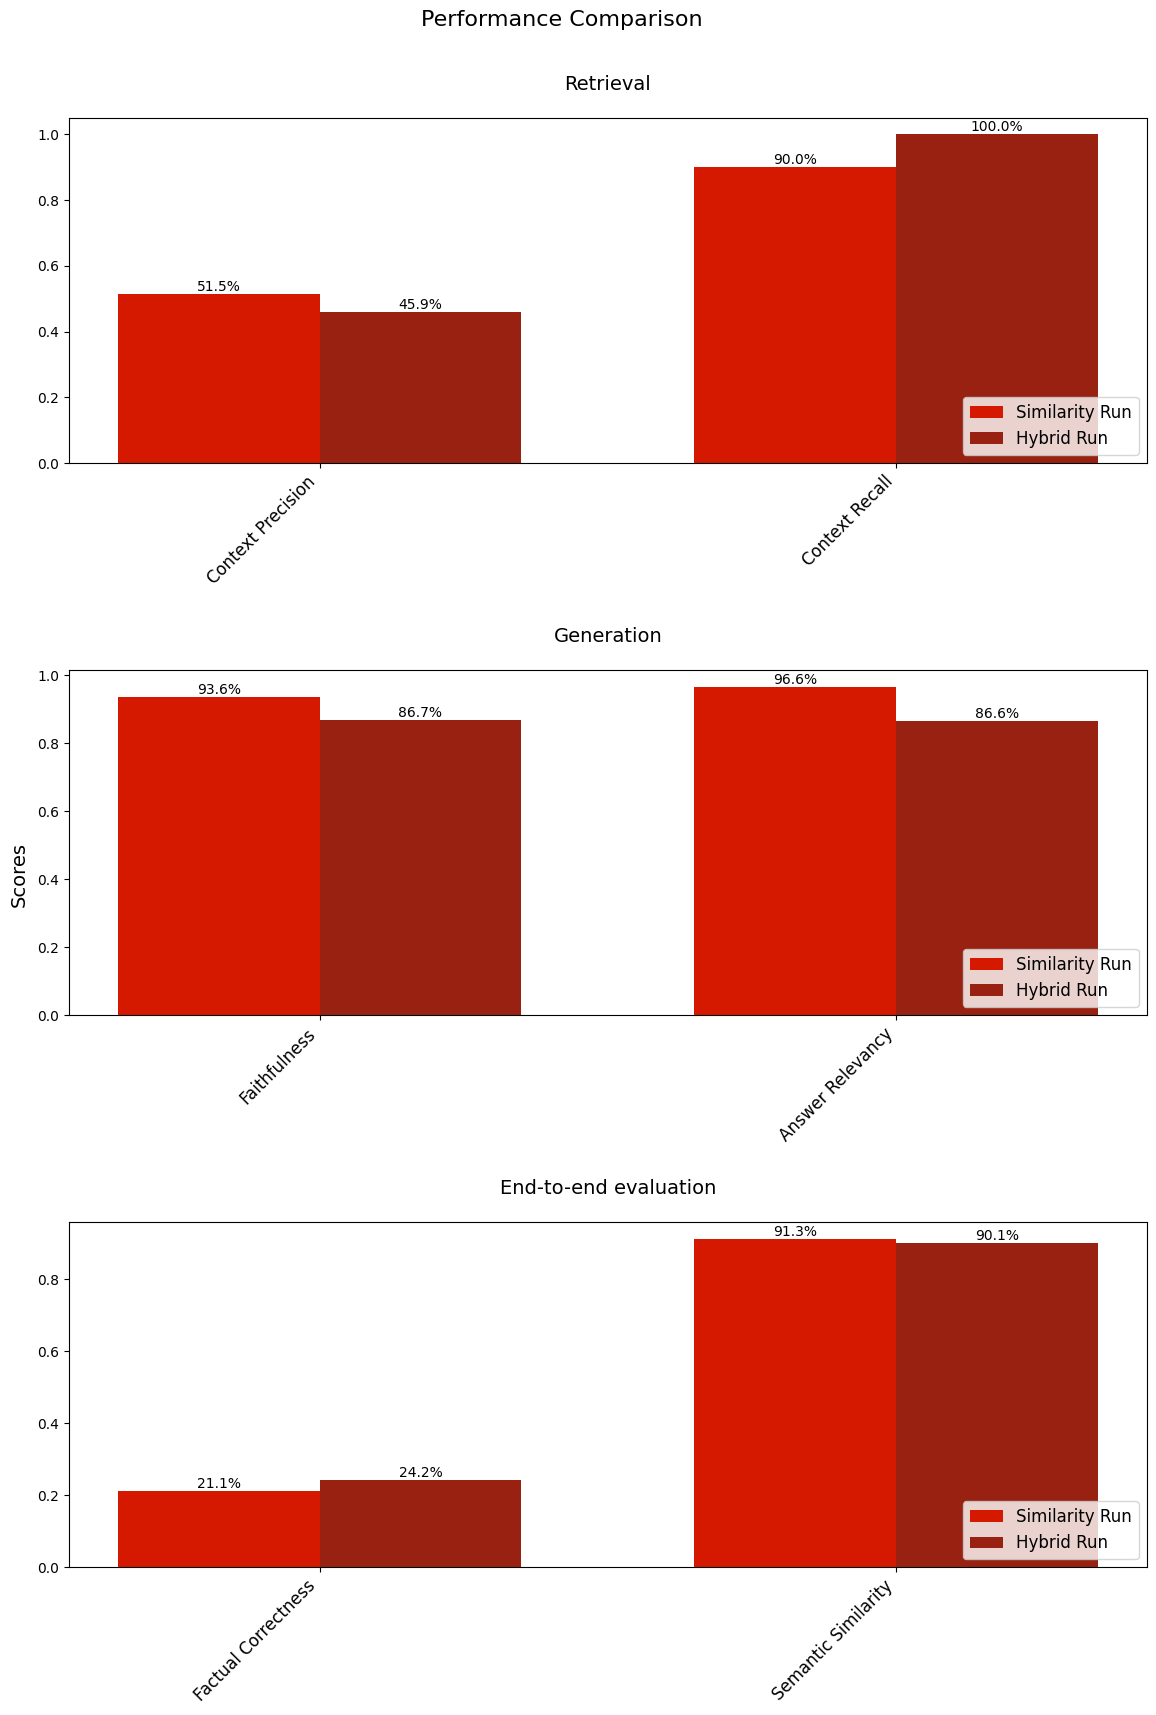

In [30]:
# Visualization - Using actual column names from the dataframe
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=False)
bar_width = 0.35
categories = ['Retrieval', 'Generation', 'End-to-end evaluation']
metrics_list = [
    ['llm_context_precision_without_reference', 'context_recall'],
    ['faithfulness', 'answer_relevancy'],
    ['factual_correctness(mode=f1)', 'semantic_similarity']
]

for i, (category, metric_list) in enumerate(zip(categories, metrics_list)):
    ax = axes[i]
    x = range(len(metric_list))
    
    similarity_bars = ax.bar(
        x, 
        comparison_df.loc[metric_list, 'Similarity Run'], 
        width=bar_width, 
        label='Similarity Run', 
        color='#D51900'
    )
    
    for bar in similarity_bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.1%}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )
    
    hybrid_bars = ax.bar(
        [i + bar_width for i in x], 
        comparison_df.loc[metric_list, 'Hybrid Run'], 
        width=bar_width, 
        label='Hybrid Run', 
        color='#992111'
    )
    
    for bar in hybrid_bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            height, 
            f'{height:.1%}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )
    
    ax.set_title(category, fontsize=14, pad=20)
    ax.set_xticks([i + bar_width / 2 for i in x])
    
    # Simplify the labels for display
    display_labels = []
    for label in metric_list:
        if label == 'llm_context_precision_without_reference':
            display_labels.append('Context Precision')
        elif label == 'context_recall':
            display_labels.append('Context Recall')
        elif label == 'answer_relevancy':
            display_labels.append('Answer Relevancy')
        elif label == 'factual_correctness(mode=f1)':
            display_labels.append('Factual Correctness')
        else:
            display_labels.append(label.replace('_', ' ').title())
    
    ax.set_xticklabels(display_labels, rotation=45, ha='right', fontsize=12)
    ax.legend(fontsize=12, loc='lower right', bbox_to_anchor=(1, 0))

fig.text(0.04, 0.5, 'Scores', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Performance Comparison', fontsize=16)

plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
plt.subplots_adjust(hspace=0.6, top=0.92)
plt.show()